# Journalist Notifications (PR #2803)

In [841]:
import numpy as np
import seaborn as sns
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd

**Note to the reader:** this is merely a sanity check. The analysis here can conclude two ciphertext distributions are distinguishable, but not that two distributions are indistinguishable. The latter must be done through understanding the crypto used. See full discussion in [PR #2803](https://github.com/freedomofpress/securedrop/pull/2803) for background and more.

# 0. Data collection and munging

Such we can rapidly generate many ciphertexts, first modify `/var/ossec` to email every minute, by setting the `frequency` to 60 in `install_files/ansible-base/securedrop-ossec-agent/var/ossec/etc/ossec.conf`:

```
  <localfile>
    <log_format>full_command</log_format>
    <command>head -1 /var/lib/securedrop/submissions_today.txt | grep '^[0-9]*$'</command>
    <frequency>60</frequency>
  </localfile>
```

Then reprovision:

```
make build-debs
vagrant provision /staging/
```

Now for each case: generate at least 50 emails for the cases of submissions, no submissions for both compression and no compression.

We record the time of the emails for later:

In [858]:
timezone = pytz.timezone("America/Los_Angeles")

begin_time_compression_on_no_submissions = timezone.localize(datetime(2018, 3, 1, 12+7, 8))  # First email at 7:08pm
end_time_compression_on_no_submissions = timezone.localize(datetime(2018, 3, 1, 12+9, 50, 29))  # Last email at 9:49pm

begin_time_compression_on_submissions = timezone.localize(datetime(2018, 3, 1, 12+9, 50, 30))  # First email at 9:50pm
end_time_compression_on_submissions = timezone.localize(datetime(2018, 3, 2, 12+4, 40, 0))  # Last email at 4:40pm the next day

begin_time_compression_off_no_submissions = timezone.localize(datetime(2018, 3, 2, 12+5, 15, 30))  # First email at 5:15pm
end_time_compression_off_no_submissions = timezone.localize(datetime(2018, 3, 2, 12+9, 50, 0))  # Last email at 9:50pm

begin_time_compression_off_submissions = timezone.localize(datetime(2018, 3, 2, 12+9, 50, 30))  # First email at 9:50pm
end_time_compression_off_submissions = timezone.localize(datetime(2018, 3, 3, 12+11, 50, 30))  # Last email at 11:30pm the next day

## 0a. Download the emails from gmail

We store the email credentials in `OSSEC_GMAIL_USERNAME` and `OSSEC_GMAIL_PASSWORD`.

In [843]:
import os
import imaplib

In [844]:
mail = imaplib.IMAP4_SSL('imap.gmail.com')
mail.login('{}@gmail.com'.format(os.getenv('OSSEC_GMAIL_USERNAME')),
           os.getenv('OSSEC_GMAIL_PASSWORD'))
mail.select('inbox')

('OK', [b'2546'])

In [845]:
_, email_listing = mail.search(None, 
                               '(SUBJECT "Submissions in the past 24h")') #'ALL')

In [846]:
email_listing

[b'1919 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1957 1967 1971 2025 2052 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202 2203 2204 2205 2206 2207 2208 2209 2210 2211 2212 2213 2214 2215 2227 2228 2229 2230 2231 2232 2233 2234 2235 2236 2237 2238 2239 2240 2241 2242 2243 2244 2245 2246 2247 2248 2249 2266 2267 2268 2269 2270 22

In [847]:
id_list = email_listing[0].split()

In [848]:
ZEROTH_LINE = '-----BEGIN PGP MESSAGE-----'
FIRST_LINE = 'Version: GnuPG v1'
LAST_LINE = '-----END PGP MESSAGE-----'

In [849]:
def fetch_and_process_email(email_id):
    # Fetch the email
    _, email_data = mail.fetch(email_id.decode('utf-8'), '(RFC822)')
    message = email_data[0][1]
    message_lines = message.decode('utf-8').split('\r\n')
    
    in_pgp_ciphertext = 0
    pgp_ciphertext = ''
    for ind, line in enumerate(message_lines):
        # Extract the date the email was received
        if 'Received' in line:
            date_raw = message_lines[ind + 4]
            email_date = datetime.strptime(date_raw.strip(), 
                                           '%a, %d %b %Y %H:%M:%S %z (%Z)')

        # Extract the ciphertext from the email
        # We will save just the Radix-64 ciphertext without the version string
        # or begin, end PGP message string.
        if line == LAST_LINE:
            in_pgp_ciphertext = 0
            return pgp_ciphertext, email_date
        
        if in_pgp_ciphertext == 1:
            pgp_ciphertext += line
        
        if line == FIRST_LINE:
            in_pgp_ciphertext = 1

In [859]:
ciphertexts_compression_on_no_submissions = []
ciphertexts_compression_on_submissions = []
ciphertexts_compression_off_no_submissions = []
ciphertexts_compression_off_submissions = []

for email_id in id_list:
    pgp_ciphertext, email_date = fetch_and_process_email(email_id)
    
    if email_date > begin_time_compression_on_no_submissions and \
       email_date < end_time_compression_on_no_submissions:
        ciphertexts_compression_on_no_submissions.append(pgp_ciphertext)
    
    if email_date > begin_time_compression_on_submissions and \
       email_date < end_time_compression_on_submissions:
        ciphertexts_compression_on_submissions.append(pgp_ciphertext)

    if email_date > begin_time_compression_off_no_submissions and \
       email_date < end_time_compression_off_no_submissions:
        ciphertexts_compression_off_no_submissions.append(pgp_ciphertext)

    if email_date > begin_time_compression_off_submissions and \
       email_date < end_time_compression_off_submissions:
        ciphertexts_compression_off_submissions.append(pgp_ciphertext)

# 1. Compute ciphertext lengths



In [860]:
def compute_ciphertext_lengths(ciphertext_list):
    radix_64_length_arr = []
    decoded_length_arr = []
    for ciphertext in ciphertext_list:
        radix_64_length_arr.append(len(ciphertext))
        
    return radix_64_length_arr, decoded_length_arr

In [861]:
radix_64_lens_compression_on_no_submissions, \
decoded_lens_compression_on_no_submissions = \
compute_ciphertext_lengths(ciphertexts_compression_on_no_submissions)

radix_64_lens_compression_on_submissions, \
decoded_lens_compression_on_submissions = \
compute_ciphertext_lengths(ciphertexts_compression_on_submissions)

radix_64_lens_compression_off_no_submissions, \
decoded_lens_compression_off_no_submissions = \
compute_ciphertext_lengths(ciphertexts_compression_off_no_submissions)

radix_64_lens_compression_off_submissions, \
decoded_lens_compression_off_submissions = \
compute_ciphertext_lengths(ciphertexts_compression_off_submissions)

# 2. Make nice summary plot

In [862]:
def ciphertext_statistics(ciphertext_list):
    print('Count: ', len(ciphertext_list))
    print('Mean: ', np.mean(ciphertext_list))
    print('Standard deviation: ', np.std(ciphertext_list))
    print('Min: ', np.min(ciphertext_list))
    print('Max: ', np.max(ciphertext_list))

In [863]:
ciphertext_statistics(radix_64_lens_compression_on_no_submissions)

Count:  54
Mean:  914.6296296296297
Standard deviation:  1.9654072831735698
Min:  913
Max:  917


In [864]:
ciphertext_statistics(radix_64_lens_compression_on_submissions)

Count:  188
Mean:  915.8723404255319
Standard deviation:  1.7997283633878747
Min:  913
Max:  917


In [865]:
ciphertext_statistics(radix_64_lens_compression_off_no_submissions)

Count:  80
Mean:  913.0
Standard deviation:  0.0
Min:  913
Max:  913


In [866]:
ciphertext_statistics(radix_64_lens_compression_off_submissions)

Count:  57
Mean:  913.0
Standard deviation:  0.0
Min:  913
Max:  913


Now we'll do walk through of the error analysis so we can make a meaningful summary plot:

In [867]:
hist_counts, bins = np.histogram(radix_64_lens_compression_on_no_submissions, density=False)
hist_normalized, bins = np.histogram(radix_64_lens_compression_on_no_submissions, density=True)

In [868]:
hist_counts

array([32,  0,  0,  0,  0,  0,  0,  0,  0, 22])

In [869]:
bins

array([913. , 913.4, 913.8, 914.2, 914.6, 915. , 915.4, 915.8, 916.2,
       916.6, 917. ])

For plotting we want to plot each point at the center of the bin:

In [870]:
bin_centers = (bins[1:] + bins[:-1]) / 2

Error bars in the x direction are just the bin width:

In [871]:
err_bin_centers = bins[1:] - bins[:-1]

We should plot error bars in the counts assuming the errors are Poisson-distributed (a reasonable assumption given the small number statistics). As such, we know that the error bar on the counts $N$ in each bin (this is the count of ciphertexts) is given by $\sigma_y = \sqrt{N}$. Since we are computing the normalized histogram, the error bar needs to be scaled appropriately: 


In [872]:
y_err_counts = hist_counts ** 0.5 

In [873]:
y_err_counts

array([5.65685425, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.69041576])

In [874]:
y_err_normalized = y_err_counts / np.sum(hist_counts)

In [875]:
y_err_normalized

array([0.10475656, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.08685955])

Now we'll write a function that does these computations and the error analysis given a list of ciphertext lengths:

In [876]:
def compute_histogram_errs(ciphertext_lengths, bins):
    hist_counts, bins = np.histogram(ciphertext_lengths, density=False, bins=bins)
    hist_normalized, bins = np.histogram(ciphertext_lengths, density=True, bins=bins)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    err_bin_centers = bins[1:] - bins[:-1]
    y_err_counts = hist_counts ** 0.5 
    y_err_normalized = y_err_counts / np.sum(hist_counts)
    return hist_normalized, y_err_normalized

In [877]:
compress_on_submissions_y, compress_on_submissions_yerr = compute_histogram_errs(radix_64_lens_compression_on_submissions, bins)

compress_off_no_submissions_y, compress_off_no_submissions_yerr = compute_histogram_errs(radix_64_lens_compression_off_no_submissions, bins)

compress_off_submissions_y, compress_off_submissions_yerr = compute_histogram_errs(radix_64_lens_compression_off_submissions, bins)

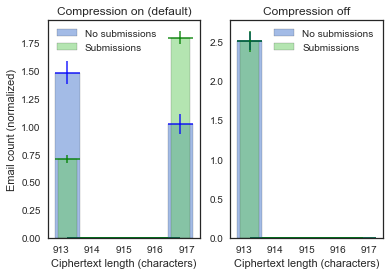

In [878]:
plt.subplot(1, 2, 1)
plt.errorbar(bin_centers, 
             hist_normalized, 
             yerr=y_err_normalized,
             xerr=err_bin_centers,
             linestyle='none', 
             ecolor='blue',
             alpha=0.75)
plt.bar(bin_centers, hist_normalized, alpha=0.5, 
        edgecolor='none', label="No submissions")

plt.errorbar(bin_centers, 
             compress_on_submissions_y, 
             yerr=compress_on_submissions_yerr, 
             xerr=err_bin_centers,
             linestyle='none', 
             ecolor='green',
             alpha=0.75)
plt.bar(bin_centers, compress_on_submissions_y, width=0.6,
        alpha=0.5, edgecolor='none', label="Submissions")

plt.title("Compression on (default)")
plt.ylabel('Email count (normalized)')
plt.xlabel('Ciphertext length (characters)')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(bin_centers, 
             compress_off_no_submissions_y, 
             yerr=compress_off_no_submissions_yerr, 
             xerr=err_bin_centers,
             linestyle='none', 
             ecolor='blue',
             alpha=0.75)
plt.bar(bin_centers, compress_off_no_submissions_y, alpha=0.5, 
        edgecolor='none', label="No submissions")

plt.errorbar(bin_centers, 
             compress_off_submissions_y, 
             yerr=compress_off_submissions_yerr, 
             xerr=err_bin_centers,
             linestyle='none', 
             ecolor='green',
             alpha=0.75)
plt.bar(bin_centers, compress_off_submissions_y, width=0.6,
        alpha=0.5, edgecolor='none', label="Submissions")

plt.title("Compression off")
plt.xlabel('Ciphertext length (characters)')
plt.legend()

If you're wondering why the normalized email count in some bins exceeds 1, it's because $N_{\mbox{emails}} = \sum_{i=0}^{N_\mbox{bins}} N_{i} \Delta x$ where $N_i$ are the counts in the ith bin.